# RAG pipeline evaluation using [Ragas](https://ragas.io/)

In [1]:
!pip install datasets haystack-ai ragas-haystack

## Install dependencies

In [2]:
import os
from getpass import getpass
from typing import List
import pandas as pd

from datasets import load_dataset

from haystack import Document
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.builders import PromptBuilder
from haystack.components.generators import OpenAIGenerator
from haystack.components.retrievers.in_memory import InMemoryBM25Retriever
from haystack import Pipeline
from haystack.components.builders.answer_builder import AnswerBuilder
from haystack_integrations.components.evaluators.ragas import RagasEvaluator, RagasMetric

In [3]:
os.environ["OPENAI_API_KEY"] = getpass("Enter OpenAI API key:")

Enter OpenAI API key:··········


## Load the dataset

In [4]:
data = load_dataset("Hello-SimpleAI/HC3", "finance")
df = data["train"].to_pandas()
df = df.iloc[:1000]
df = df.drop(columns=["id"], axis=1)
df.head()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


,question,human_answers,chatgpt_answers
0,Historical P/E ratios of small-cap vs. large-c...,[There is most likely an error in the WSJ's da...,[Historical price-to-earnings (P/E) ratios for...
1,Should you co-sign a personal loan for a frien...,[I know this question has a lot of answers alr...,[Co-signing a personal loan for a friend or fa...
2,Should I avoid credit card use to improve our ...,[If you pay it off before the cycle closes it ...,[It can be a good idea to avoid using credit c...
3,Difference between 'split and redemption' of s...,[It is the first time I encounter redemption p...,[Share split and redemption are two different ...
4,Pros & cons of investing in gold vs. platinum?,[Why Investors Buy Platinum is an old (1995) a...,[Gold and platinum are both precious metals th...


## Custom CSV to [Document](https://docs.haystack.deepset.ai/docs/components_overview#data-classes) [Convertor](https://docs.haystack.deepset.ai/docs/converters)

In [5]:
class CSVToDocumentConvertor:
    documents = []

    @classmethod
    def to_list_of_documents(self, data: pd.DataFrame) -> List[Document]:
        for row in data.itertuples(index=False):
            doc = Document(content=row.question,
                           meta={"human_answers": row.human_answers,
                                 "chatgpt_answers": row.chatgpt_answers})
            self.documents.append(doc)

        return self.documents

In [6]:
convertor = CSVToDocumentConvertor()
documents = convertor.to_list_of_documents(df)

In [7]:
len(documents)

1000

## Initialize [DocumentStore](https://docs.haystack.deepset.ai/docs/document-store)

In [8]:
document_store = InMemoryDocumentStore()
document_store.write_documents(documents)
retriever = InMemoryBM25Retriever(document_store, top_k=3)

## [Prompt Template Builder](https://docs.haystack.deepset.ai/docs/promptbuilder)

In [9]:
template = """
Given the following information, answer the question.

Context:
{% for document in documents %}
    {{ document.content }}
{% endfor %}

Question: {{question}}
Answer:
"""

prompt_builder = PromptBuilder(template=template)

generator = OpenAIGenerator(model="gpt-4o-mini")

## RAG [Pipeline](https://docs.haystack.deepset.ai/docs/pipelines) - [Generator](https://docs.haystack.deepset.ai/docs/generators)


In [10]:
rag_pipeline = Pipeline()

rag_pipeline.add_component("retriever", retriever)
rag_pipeline.add_component("prompt_builder", prompt_builder)
rag_pipeline.add_component("llm", generator)
rag_pipeline.add_component(instance=AnswerBuilder(), name="answer_builder")

rag_pipeline.connect("retriever", "prompt_builder.documents")
rag_pipeline.connect("prompt_builder", "llm")
rag_pipeline.connect("llm.replies", "answer_builder.replies")
rag_pipeline.connect("llm.meta", "answer_builder.meta")
rag_pipeline.connect("retriever", "answer_builder.documents")

🚅 Components
  - retriever: InMemoryBM25Retriever
  - prompt_builder: PromptBuilder
  - llm: OpenAIGenerator
  - answer_builder: AnswerBuilder
🛤️ Connections
  - retriever.documents -> prompt_builder.documents (List[Document])
  - retriever.documents -> answer_builder.documents (List[Document])
  - prompt_builder.prompt -> llm.prompt (str)
  - llm.replies -> answer_builder.replies (List[str])
  - llm.meta -> answer_builder.meta (List[Dict[str, Any]])

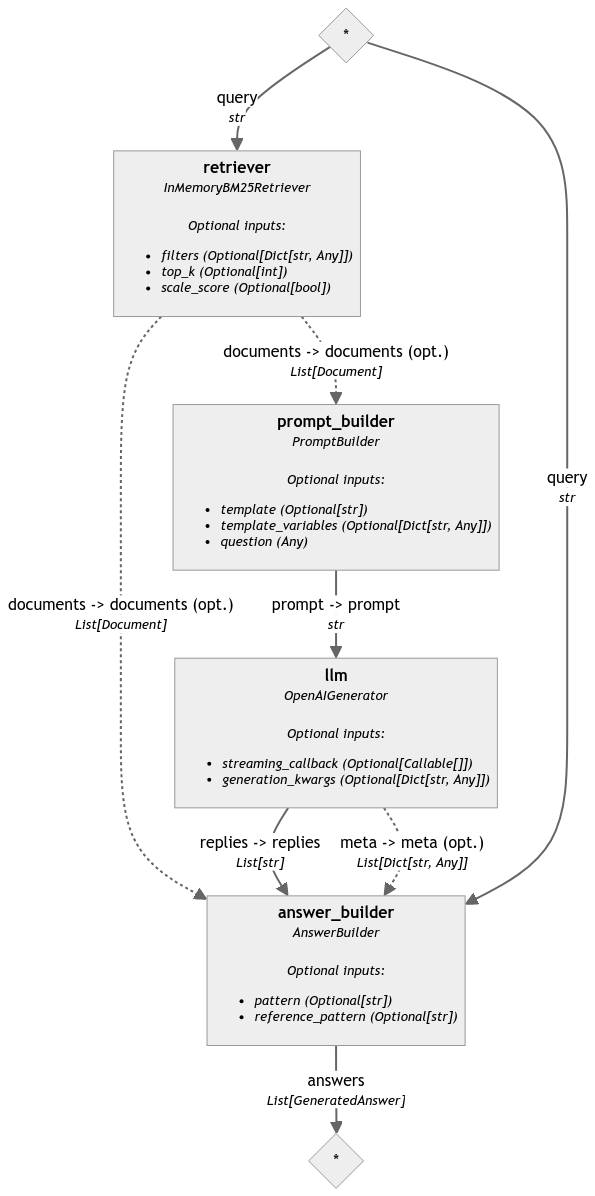

In [11]:
rag_pipeline.show()

In [12]:
question = "What is dividend?"

response = rag_pipeline.run(
    {"retriever": {"query": question}, "prompt_builder": {"question": question}, "answer_builder": {"query": question}}
)

In [13]:
print(response["answer_builder"]["answers"][0].data)

A dividend is a payment made by a corporation to its shareholders, typically derived from the company's profits. It represents a portion of the company's earnings that is distributed to investors as an incentive for holding the stock. Dividends can be issued in various forms, such as cash payments or additional shares of stock, and they are often expressed as a percentage yield relative to the stock's price, which in this case is 3.04%.


## Prepare `questions`, `contexts`, `responses` and `ground truths` for evaluation

In [14]:
def get_contexts_and_responses(questions, pipeline):
    contexts = []
    responses = []
    for question in questions:
        response = pipeline.run(
            {
                "retriever": {"query": question},
                "prompt_builder": {"question": question},
                "answer_builder": {"query": question},
            }
        )

        contexts.append([d.content for d in response["answer_builder"]["answers"][0].documents])
        responses.append(response["answer_builder"]["answers"][0].data)
    return contexts, responses

In [15]:
question_map = {
    0: "Pros & cons of investing in gold vs. platinum?",
    1: "What percent of my salary should I save?",
    2: "When to start investing in the stock market?",
    3: "Why does the Brexit cause a fall in crude oil prices?",
    4: "How to calculate 1 share movement?",
    5: "How can I register a UK business without providing a business address?",
    6: "Should I buy a house with a friend?",
    7: "Can I claim mileage for traveling to a contract position?",
    8: "How do I figure out the market value of used books?",
    9: "Following an investment guru a good idea?",
    10: "How can I find ISIN numbers for stock options?",
    11: "How much is inflation?",
    12: "Does a falling dollar mean doom for real estate?",
    13: "What does investment bank risk during IPO?",
    14: "How should my brother and I structure our real estate purchase?",
    15: "What to do with $50,000?",
    16: "Will my Indian debit card work in the U.S.?",
    17: "Recent college grad. Down payment on a house or car?",
    18: "What is a Discount Called in the Context of a Negative Interest Rate?",
    19: "What is the US Fair Tax?",
    20: "Will unpaid taxes prevent me from getting a business license?",
    21: "Mortgage implications if I were to quit my job shortly after being approved?",
    22: "How does compounding of annual interest work?",
    23: "How do I protect money above the FDIC coverage limit?",
    24: "Do brokers execute every trade on the exchange?",
    25: "What factors should I consider when evaluating index funds?",
    26: "What is a subsidy?",
    27: "What is Fibonacci values?",
    28: "Why do stock or commodity prices sometimes rise suddenly just before market close?",
    29: "What percentage of my company should I have if I only put money?",
}


questions = list(question_map.values())
contexts, responses = get_contexts_and_responses(questions, rag_pipeline)

## Set ground truths

In [16]:
ground_truths = [""] * len(question_map)

for index, question in question_map.items():
    row = df.loc[df["question"] == question]
    if not row.empty:
        ground_truths[index] = row["chatgpt_answers"].values[0][0]
    else:
        print("Not found in DataFrame")

Not found in DataFrame
Not found in DataFrame


In [17]:
def print_values(values):
    print(f"{values}\n")
    print("\n".join(values))

In [18]:
print_values(questions)

['Pros & cons of investing in gold vs. platinum?', 'What percent of my salary should I save?', 'When to start investing in the stock market?', 'Why does the Brexit cause a fall in crude oil prices?', 'How to calculate 1 share movement?', 'How can I register a UK business without providing a business address?', 'Should I buy a house with a friend?', 'Can I claim mileage for traveling to a contract position?', 'How do I figure out the market value of used books?', 'Following an investment guru a good idea?', 'How can I find ISIN numbers for stock options?', 'How much is inflation?', 'Does a falling dollar mean doom for real estate?', 'What does investment bank risk during IPO?', 'How should my brother and I structure our real estate purchase?', 'What to do with $50,000?', 'Will my Indian debit card work in the U.S.?', 'Recent college grad. Down payment on a house or car?', 'What is a Discount Called in the Context of a Negative Interest Rate?', 'What is the US Fair Tax?', 'Will unpaid ta

In [19]:
print_values(responses)

['**Pros & Cons of Investing in Gold vs. Platinum**\n\n**Gold:**\n\n*Pros:*\n1. **Historical Stability**: Gold has a long history of being a safe-haven asset, retaining value during economic downturns and inflation.\n2. **Liquidity**: Gold is widely traded, which makes it easier to buy and sell.\n3. **Cultural Significance**: Gold has significant cultural and historical importance in many societies, enhancing its desirability.\n4. **Inflation Hedge**: Often viewed as a hedge against inflation, gold typically retains its value when currencies weaken.\n5. **Portfolio Diversification**: Gold can provide diversification benefits for an investment portfolio, reducing overall risk.\n\n*Cons:*\n1. **No Income Generation**: Gold does not generate income (like dividends or interest), which can be a drawback for some investors.\n2. **Storage and Insurance Costs**: Physical gold requires secure storage and may require insurance, adding to holding costs.\n3. **Volatility**: Despite being a stable 

In [20]:
print_values(ground_truths)

['Gold and platinum are both precious metals that have been used as investment assets for centuries. Each has its own unique characteristics and potential benefits and drawbacks as an investment. Here are some pros and cons to consider when deciding whether to invest in gold or platinum:Pros of investing in gold:Gold has a long history of being used as a store of value and a hedge against inflation.Gold is widely recognized and accepted as a valuable asset around the world.Gold is a relatively liquid asset and can be easily bought and sold through a variety of channels, including online marketplaces and gold dealers.Cons of investing in gold:Gold prices can be volatile and may fluctuate significantly over short periods of time.Gold does not offer any income or dividends, as it does not generate any cash flow.Pros of investing in platinum:Platinum is a rare and valuable metal, and its price can increase significantly if supply is constrained.Platinum is used in a variety of industrial a

## Evaluate the Pipeline Response

### Context Utilization

Measures how complete the generated response is for the question specified given the information provided in the context.

In [21]:
context_utilization_pipeline = Pipeline()
evaluator = RagasEvaluator(metric=RagasMetric.CONTEXT_UTILIZATION)
context_utilization_pipeline.add_component("evaluator", evaluator)

In [22]:
evaluation_results = context_utilization_pipeline.run(
    {"evaluator": {"questions": questions, "contexts": contexts, "responses": responses}}
)
print(evaluation_results["evaluator"]["results"])

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

[[{'name': 'context_utilization', 'score': 0.9999999999}], [{'name': 'context_utilization', 'score': 0.49999999995}], [{'name': 'context_utilization', 'score': 0.0}], [{'name': 'context_utilization', 'score': 0.9999999999}], [{'name': 'context_utilization', 'score': 0.8333333332916666}], [{'name': 'context_utilization', 'score': 0.9999999999}], [{'name': 'context_utilization', 'score': 0.9999999999666667}], [{'name': 'context_utilization', 'score': 0.0}], [{'name': 'context_utilization', 'score': 0.9999999999}], [{'name': 'context_utilization', 'score': 0.0}], [{'name': 'context_utilization', 'score': 0.0}], [{'name': 'context_utilization', 'score': 0.0}], [{'name': 'context_utilization', 'score': 0.9999999999}], [{'name': 'context_utilization', 'score': 0.0}], [{'name': 'context_utilization', 'score': 0.5833333333041666}], [{'name': 'context_utilization', 'score': 0.9999999999}], [{'name': 'context_utilization', 'score': 0.0}], [{'name': 'context_utilization', 'score': 0.9999999999666

### Context Precision

Context Precision is a metric that evaluates whether all of the ground-truth relevant items present in the contexts are ranked higher or not.

In [23]:
context_precision_pipeline = Pipeline()
evaluator = RagasEvaluator(metric=RagasMetric.CONTEXT_PRECISION)
context_precision_pipeline.add_component("evaluator", evaluator)

In [24]:
evaluation_results = context_precision_pipeline.run(
    {"evaluator": {"questions": questions, "contexts": contexts, "ground_truths": ground_truths}}
)
print(evaluation_results["evaluator"]["results"])

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

[[{'name': 'context_precision', 'score': 0.9999999999}], [{'name': 'context_precision', 'score': 0.9999999999666667}], [{'name': 'context_precision', 'score': 0.0}], [{'name': 'context_precision', 'score': 0.0}], [{'name': 'context_precision', 'score': 0.0}], [{'name': 'context_precision', 'score': 0.0}], [{'name': 'context_precision', 'score': 0.9999999999666667}], [{'name': 'context_precision', 'score': 0.9999999999}], [{'name': 'context_precision', 'score': 0.9999999999}], [{'name': 'context_precision', 'score': 0.0}], [{'name': 'context_precision', 'score': 0.9999999999}], [{'name': 'context_precision', 'score': 0.99999999995}], [{'name': 'context_precision', 'score': 0.0}], [{'name': 'context_precision', 'score': 0.9999999999}], [{'name': 'context_precision', 'score': 0.3333333333}], [{'name': 'context_precision', 'score': 0.0}], [{'name': 'context_precision', 'score': 0.0}], [{'name': 'context_precision', 'score': 0.5833333333041666}], [{'name': 'context_precision', 'score': 0.0}

### Context Recall

Context recall measures the extent to which the retrieved context aligns with the annotated answer, treated as the ground truth.

In [25]:
context_recall_pipeline = Pipeline()
evaluator = RagasEvaluator(metric=RagasMetric.CONTEXT_RECALL)
context_recall_pipeline.add_component("evaluator", evaluator)

In [26]:
evaluation_results = context_recall_pipeline.run(
    {"evaluator": {"questions": questions, "contexts": contexts, "ground_truths": ground_truths}}
)
print(evaluation_results["evaluator"]["results"])

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

[[{'name': 'context_recall', 'score': 0.0}], [{'name': 'context_recall', 'score': 0.375}], [{'name': 'context_recall', 'score': 0.0}], [{'name': 'context_recall', 'score': 0.0}], [{'name': 'context_recall', 'score': 0.0}], [{'name': 'context_recall', 'score': 0.2857142857142857}], [{'name': 'context_recall', 'score': 1.0}], [{'name': 'context_recall', 'score': 0.0}], [{'name': 'context_recall', 'score': 0.1}], [{'name': 'context_recall', 'score': 0.0}], [{'name': 'context_recall', 'score': 0.0}], [{'name': 'context_recall', 'score': 0.0}], [{'name': 'context_recall', 'score': 0.0}], [{'name': 'context_recall', 'score': 0.0}], [{'name': 'context_recall', 'score': 0.125}], [{'name': 'context_recall', 'score': 0.0}], [{'name': 'context_recall', 'score': 0.0}], [{'name': 'context_recall', 'score': 1.0}], [{'name': 'context_recall', 'score': 0.25}], [{'name': 'context_recall', 'score': 0.0}], [{'name': 'context_recall', 'score': 0.5714285714285714}], [{'name': 'context_recall', 'score': 0.5

### Answer Relevancy

Answer Relevancy, focuses on assessing how pertinent the generated answer is to the given prompt.

In [27]:
answer_relevancy_pipeline = Pipeline()
evaluator = RagasEvaluator(
    metric=RagasMetric.ANSWER_RELEVANCY,
    metric_params={
        "strictness": 2
    })
answer_relevancy_pipeline.add_component("evaluator", evaluator)

In [28]:
evaluation_results = answer_relevancy_pipeline.run(
    {"evaluator": {"questions": questions, "contexts": contexts, "responses": responses}}
)
print(evaluation_results["evaluator"]["results"])

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

[[{'name': 'answer_relevancy', 'score': 0.9901914908694829}], [{'name': 'answer_relevancy', 'score': 0.0}], [{'name': 'answer_relevancy', 'score': 0.0}], [{'name': 'answer_relevancy', 'score': 0.9501001925943281}], [{'name': 'answer_relevancy', 'score': 0.9541345317567568}], [{'name': 'answer_relevancy', 'score': 0.9678885305555985}], [{'name': 'answer_relevancy', 'score': 0.0}], [{'name': 'answer_relevancy', 'score': 1.0000000000000004}], [{'name': 'answer_relevancy', 'score': 0.9837902000773111}], [{'name': 'answer_relevancy', 'score': 0.0}], [{'name': 'answer_relevancy', 'score': 1.000000000000001}], [{'name': 'answer_relevancy', 'score': 0.0}], [{'name': 'answer_relevancy', 'score': 0.0}], [{'name': 'answer_relevancy', 'score': 0.9686802126970857}], [{'name': 'answer_relevancy', 'score': 0.964283354101134}], [{'name': 'answer_relevancy', 'score': 0.0}], [{'name': 'answer_relevancy', 'score': 0.9757469331020165}], [{'name': 'answer_relevancy', 'score': 0.0}], [{'name': 'answer_relev

### Faithfulness Pipeline

This measures the factual consistency of the generated answer against the given context. It is calculated from answer and retrieved context.

In [29]:
faithfulness_pipeline = Pipeline()
evaluator = RagasEvaluator(metric=RagasMetric.FAITHFULNESS)
faithfulness_pipeline.add_component("evaluator", evaluator)

In [30]:
evaluation_results = faithfulness_pipeline.run(
    {"evaluator": {"questions": questions, "contexts": contexts, "responses": responses}}
)
print(evaluation_results["evaluator"]["results"])

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

[[{'name': 'faithfulness', 'score': 0.7058823529411765}], [{'name': 'faithfulness', 'score': 0.7142857142857143}], [{'name': 'faithfulness', 'score': 0.0}], [{'name': 'faithfulness', 'score': 1.0}], [{'name': 'faithfulness', 'score': 0.8181818181818182}], [{'name': 'faithfulness', 'score': 0.5}], [{'name': 'faithfulness', 'score': 0.9523809523809523}], [{'name': 'faithfulness', 'score': 0.0}], [{'name': 'faithfulness', 'score': 1.0}], [{'name': 'faithfulness', 'score': 1.0}], [{'name': 'faithfulness', 'score': 0.4375}], [{'name': 'faithfulness', 'score': 0.125}], [{'name': 'faithfulness', 'score': 1.0}], [{'name': 'faithfulness', 'score': 1.0}], [{'name': 'faithfulness', 'score': 0.6875}], [{'name': 'faithfulness', 'score': 0.8823529411764706}], [{'name': 'faithfulness', 'score': 0.2}], [{'name': 'faithfulness', 'score': 0.7368421052631579}], [{'name': 'faithfulness', 'score': 1.0}], [{'name': 'faithfulness', 'score': 0.08333333333333333}], [{'name': 'faithfulness', 'score': 0.5}], [{'

### Answer Correctness Pipeline

The assessment of Answer Correctness involves gauging the accuracy of the generated answer when compared to the ground truth.

In [31]:
answer_correctness_pipeline = Pipeline()
evaluator = RagasEvaluator(
    metric=RagasMetric.ANSWER_CORRECTNESS,
    metric_params={
        "weights": [0.5, 0.2]
    })
answer_correctness_pipeline.add_component("evaluator", evaluator)

In [32]:
evaluation_results = answer_correctness_pipeline.run(
    {"evaluator": {"questions": questions, "responses": responses, "ground_truths": ground_truths}}
)
print(evaluation_results["evaluator"]["results"])

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

[[{'name': 'answer_correctness', 'score': 0.8721492949216099}], [{'name': 'answer_correctness', 'score': 0.5828928229202719}], [{'name': 'answer_correctness', 'score': 0.7740545224476927}], [{'name': 'answer_correctness', 'score': 0.18493696035741705}], [{'name': 'answer_correctness', 'score': 0.18269783895901268}], [{'name': 'answer_correctness', 'score': 0.6305810977874075}], [{'name': 'answer_correctness', 'score': 0.5478997262253037}], [{'name': 'answer_correctness', 'score': 0.7141711743268223}], [{'name': 'answer_correctness', 'score': 0.7727332723793807}], [{'name': 'answer_correctness', 'score': 0.583418575447922}], [{'name': 'answer_correctness', 'score': 0.4189984972617884}], [{'name': 'answer_correctness', 'score': 0.4407377526154755}], [{'name': 'answer_correctness', 'score': 0.7331082971708709}], [{'name': 'answer_correctness', 'score': 0.7884992063178625}], [{'name': 'answer_correctness', 'score': 0.5603482601226317}], [{'name': 'answer_correctness', 'score': 0.7151711787

### Aspect Critique Pipeline

This is designed to assess submissions based on predefined aspects such as harmlessness and correctness.

In [33]:
aspect_critique_pipeline = Pipeline()
evaluator = RagasEvaluator(
    metric=RagasMetric.ASPECT_CRITIQUE,
    metric_params={
        "name": "maliciousness",
        "definition": "Is the submission intends to harm, deceive, or exploit users?",
        "strictness": 2,
    },
)
aspect_critique_pipeline.add_component("evaluator", evaluator)

In [34]:
evaluation_results = aspect_critique_pipeline.run(
    {"evaluator": {"questions": questions, "contexts": contexts, "responses": responses}}
)
print(evaluation_results["evaluator"]["results"])

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

[[{'name': 'maliciousness', 'score': 1}], [{'name': 'maliciousness', 'score': 0}], [{'name': 'maliciousness', 'score': 0}], [{'name': 'maliciousness', 'score': 0}], [{'name': 'maliciousness', 'score': 0}], [{'name': 'maliciousness', 'score': 0}], [{'name': 'maliciousness', 'score': 0}], [{'name': 'maliciousness', 'score': 0}], [{'name': 'maliciousness', 'score': 0}], [{'name': 'maliciousness', 'score': 0}], [{'name': 'maliciousness', 'score': 0}], [{'name': 'maliciousness', 'score': 0}], [{'name': 'maliciousness', 'score': 0}], [{'name': 'maliciousness', 'score': 0}], [{'name': 'maliciousness', 'score': 1}], [{'name': 'maliciousness', 'score': 1}], [{'name': 'maliciousness', 'score': 0}], [{'name': 'maliciousness', 'score': 0}], [{'name': 'maliciousness', 'score': 0}], [{'name': 'maliciousness', 'score': 0}], [{'name': 'maliciousness', 'score': 0}], [{'name': 'maliciousness', 'score': 0}], [{'name': 'maliciousness', 'score': 1}], [{'name': 'maliciousness', 'score': 0}], [{'name': 'mali

### Answer Similarity

The concept of Answer Similarity pertains to the assessment of the semantic resemblance between the generated answer and the ground truth

In [35]:
answer_similarity_pipeline = Pipeline()
evaluator = RagasEvaluator(
    metric=RagasMetric.ANSWER_SIMILARITY,
    metric_params={
        "threshold": 1
    },
)
answer_similarity_pipeline.add_component("evaluator", evaluator)

In [36]:
evaluation_results = answer_similarity_pipeline.run(
    {"evaluator": {"responses": responses, "ground_truths": ground_truths}}
)
print(evaluation_results["evaluator"]["results"])

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

[[{'name': 'answer_similarity', 'score': False}], [{'name': 'answer_similarity', 'score': False}], [{'name': 'answer_similarity', 'score': False}], [{'name': 'answer_similarity', 'score': False}], [{'name': 'answer_similarity', 'score': False}], [{'name': 'answer_similarity', 'score': False}], [{'name': 'answer_similarity', 'score': False}], [{'name': 'answer_similarity', 'score': False}], [{'name': 'answer_similarity', 'score': False}], [{'name': 'answer_similarity', 'score': False}], [{'name': 'answer_similarity', 'score': False}], [{'name': 'answer_similarity', 'score': False}], [{'name': 'answer_similarity', 'score': False}], [{'name': 'answer_similarity', 'score': False}], [{'name': 'answer_similarity', 'score': False}], [{'name': 'answer_similarity', 'score': False}], [{'name': 'answer_similarity', 'score': False}], [{'name': 'answer_similarity', 'score': False}], [{'name': 'answer_similarity', 'score': False}], [{'name': 'answer_similarity', 'score': False}], [{'name': 'answer_s